In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import random
from IPython.display import display
import pystan
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pickle

### stanfit_to_dataframe

In [54]:
def stanfit_to_dataframe(fit, pars=None):
    """
    Parameters
    ==========
    fit : pystan.StanFit4model
    """
    import pandas
    summary = fit.summary(pars=pars)
    columns = summary['summary_colnames']
    index = summary['summary_rownames']
    data = summary['summary']
    return pandas.DataFrame(data, index, columns)

# Table of Contents
 <p><div class="lev3 toc-item"><a href="#stanfit_to_dataframe" data-toc-modified-id="stanfit_to_dataframe-001"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span>stanfit_to_dataframe</a></div><div class="lev1 toc-item"><a href="#エクササイズ18.1" data-toc-modified-id="エクササイズ18.1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>エクササイズ18.1</a></div><div class="lev2 toc-item"><a href="#図-18.8の右" data-toc-modified-id="図-18.8の右-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>図 18.8の右</a></div><div class="lev2 toc-item"><a href="#x_1-=-0-のとき" data-toc-modified-id="x_1-=-0-のとき-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>$x_1 = 0$ のとき</a></div><div class="lev2 toc-item"><a href="#x_1-=-10-のとき" data-toc-modified-id="x_1-=-10-のとき-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>$x_1 = 10$ のとき</a></div><div class="lev2 toc-item"><a href="#図からの計算" data-toc-modified-id="図からの計算-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>図からの計算</a></div><div class="lev1 toc-item"><a href="#エクササイズ18.2" data-toc-modified-id="エクササイズ18.2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>エクササイズ18.2</a></div><div class="lev2 toc-item"><a href="#読み込み可視化" data-toc-modified-id="読み込み可視化-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>読み込み可視化</a></div><div class="lev2 toc-item"><a href="#(A)２つの予測変数による重回帰分析" data-toc-modified-id="(A)２つの予測変数による重回帰分析-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>(A)２つの予測変数による重回帰分析</a></div><div class="lev2 toc-item"><a href="#(B)1予測変数" data-toc-modified-id="(B)1予測変数-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>(B)1予測変数</a></div><div class="lev2 toc-item"><a href="#(C)データの101行目から150目" data-toc-modified-id="(C)データの101行目から150目-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>(C)データの101行目から150目</a></div><div class="lev2 toc-item"><a href="#(D)1予測変数" data-toc-modified-id="(D)1予測変数-25"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>(D)1予測変数</a></div><div class="lev2 toc-item"><a href="#エクササイズ18.2のポイント" data-toc-modified-id="エクササイズ18.2のポイント-26"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>エクササイズ18.2のポイント</a></div><div class="lev1 toc-item"><a href="#エクササイズ18.3" data-toc-modified-id="エクササイズ18.3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>エクササイズ18.3</a></div><div class="lev1 toc-item"><a href="#エクササイズ18.4" data-toc-modified-id="エクササイズ18.4-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>エクササイズ18.4</a></div>

# エクササイズ18.1
【目的：重回帰の交互作用の理解】

## 図 18.8の右

![](2017-11-08 21.29.51.png)  
式18.4 $\mu = \beta_0 + \beta_1x_1 + (\beta_2 + \beta_{1\times 2}x_1)x_2$   
つまり、$x_2$の傾きは、$\beta_2 + \beta_{1\times 2}x_1$  
今回の問題の場合は、$2 + 0.2x_1$が$x_2$の傾き


## $x_1 = 0$ のとき

傾き：2

## $x_1 = 10$ のとき

傾き：4

## 図からの計算

- $x_1 = 0$の時、傾き2
    - $y = 10(x_2 = 0)$
    - $y = 30(x_2 = 10)$

- $x_1 = 10$の時、傾き4
    - $y = 0(x_2 = 0)$
    - $y = 40(x_2 = 10)$

# エクササイズ18.2
【目的：予測変数が互いに相関していない場合の、変数の投入・除去の効果の確認、共分散分析の前置き】

## 読み込み可視化

In [13]:
Mydata = pd.read_csv('MultLinRegrPlotUnif.csv')

In [14]:
Mydata.columns

Index(['x1', 'x2', 'y'], dtype='object')

In [15]:
Mydata.head(2)

,x1,x2,y
0,6.248172,6.413018,27.728072
1,0.547031,6.056001,22.440026


In [213]:
Mydata.tail(2)

,x1,x2,y
398,7.900203,8.825103,36.219568
399,0.011432,5.872943,21.160379


In [16]:
Mydata.shape

(400, 3)

In [173]:
from mpl_toolkits.mplot3d import Axes3D

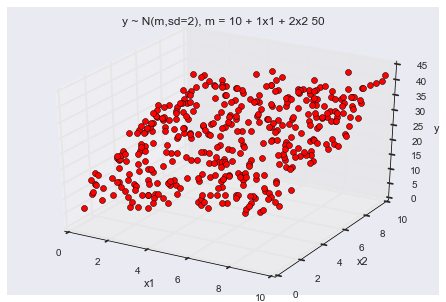

In [216]:
fig = plt.figure()
ax = Axes3D(fig)

ax.set_title("y ~ N(m,sd=2), m = 10 + 1x1 + 2x2 50")

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")

ax.plot(np.array(Mydata['x1']),np.array(Mydata['x2']), np.array(Mydata['y']), "o", color="#ff0000",ms=6 ,mew=0.5);

## (A)２つの予測変数による重回帰分析

In [189]:
N = 400
M = 2

In [190]:
X = np.concatenate([np.ones(N),Mydata['x1'],Mydata['x2']]).reshape(3,N)
X = X.T

In [41]:
standata = {'N':N, 'M':3, 'X':X, 'Y':Mydata['y']}

In [46]:
model="""
data {
  int<lower =0> N;
  int<lower =0> M;
  vector[N] Y;
  matrix[N,M] X;
}

parameters {
  vector[M] beta;
  real<lower=0> sig;
}

model {
  Y ~ normal(X*beta,sig);
  beta ~ normal(0,100);
  sig ~ student_t(4,0,5);
}

"""

In [47]:
sm = pystan.StanModel(model_code=model)

In [48]:
fit = sm.sampling(standata)

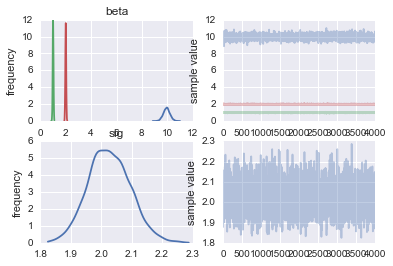

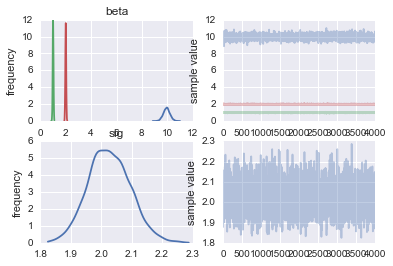

In [192]:
fit.plot()

In [50]:
with open('18_2.pickle', 'wb') as f:
    pickle.dump(sm, f)
    pickle.dump(fit,f)

In [ ]:
with open('18_2.pickle', 'rb') as f: # 読み込む時
    sm = pickle.load(f)
    fit = pickle.load(f)

In [56]:
stanfit_to_dataframe(fit)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta[0],9.950705,0.005552,0.260593,9.443962,9.782230,9.953573,10.115552,10.476434,2203.0,1.001037
beta[1],0.996125,0.000647,0.033177,0.931516,0.974072,0.996159,1.018838,1.061134,2632.0,1.001470
beta[2],1.995000,0.000680,0.034408,1.927427,1.971513,1.995102,2.018114,2.063010,2563.0,0.999755
sig,2.026138,0.001268,0.069310,1.894899,1.978213,2.023927,2.072360,2.166341,2987.0,1.000031
lp__,-481.121900,0.035069,1.405399,-484.766002,-481.783746,-480.798544,-480.101960,-479.406261,1606.0,0.999935


In [193]:
data = fit.extract()

In [194]:
data.keys()

odict_keys(['beta', 'sig', 'lp__'])

In [195]:
data['beta'].shape

(4000, 3)

In [196]:
np.mean(data['beta'][:,2])

1.9949998276929968

In [116]:
fitdata = pd.DataFrame({'beta0' : data['beta'][:,0] , 'beta1' : data['beta'][:,1] , 'beta2' : data['beta'][:,2] , 'sigma' :data['sig']})

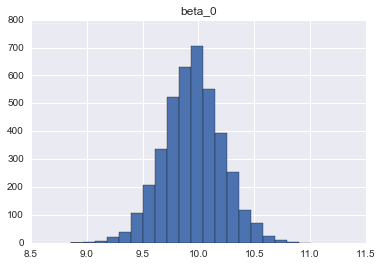

In [129]:
plt.hist(fitdata['beta0'],bins=20)
plt.title('beta_0');

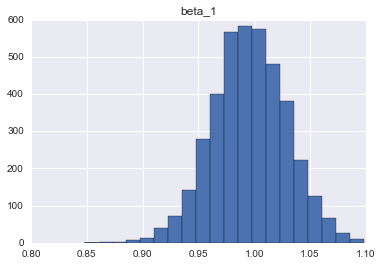

In [132]:
plt.hist(fitdata['beta1'],bins=20)
plt.title('beta_1');

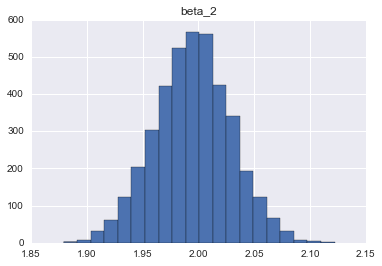

In [131]:
plt.hist(fitdata['beta2'],bins=20)
plt.title('beta_2');

## (B)1予測変数

In [134]:
Mydata.head(2)

,x1,x2,y
0,6.248172,6.413018,27.728072
1,0.547031,6.056001,22.440026


In [136]:
standata.keys()

dict_keys(['N', 'M', 'X', 'Y'])

In [139]:
X = np.concatenate([np.ones(N),Mydata['x1']]).reshape(2,N)
X = X.T

In [141]:
standata = {'N':N, 'M':2, 'X':X, 'Y':Mydata['y']}

In [142]:
fit_b = sm.sampling(standata)

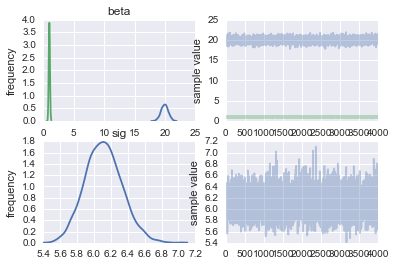

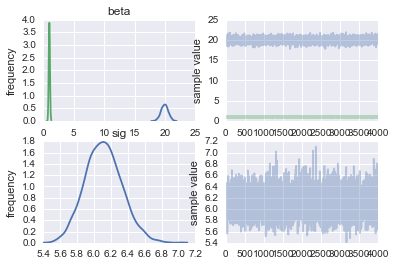

In [143]:
fit_b.plot()

In [144]:
stanfit_to_dataframe(fit_b)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta[0],19.947439,0.014831,0.599157,18.748332,19.541609,19.953767,20.348359,21.120773,1632.0,1.001340
beta[1],1.009096,0.002600,0.101095,0.813180,0.940862,1.009681,1.078059,1.203118,1512.0,1.001405
sig,6.114118,0.004303,0.218752,5.709558,5.961903,6.108372,6.254944,6.568900,2584.0,1.000802
lp__,-923.625425,0.032148,1.182516,-926.641265,-924.175810,-923.336313,-922.753280,-922.259261,1353.0,1.000708


In [145]:
with open('18_2_b.pickle', 'wb') as f:
    pickle.dump(fit_b,f)

In [146]:
data_b = fit_b.extract()

In [147]:
data_b

OrderedDict([('beta', array([[ 20.3400961 ,   1.00361156],
                     [ 20.71071409,   0.85965329],
                     [ 19.82197042,   1.05869444],
                     ..., 
                     [ 20.09424074,   0.95016077],
                     [ 19.91387529,   0.98429777],
                     [ 21.03643074,   0.84059339]])),
             ('sig',
              array([ 6.05103907,  6.00380006,  6.18298508, ...,  6.59848366,
                      6.2212216 ,  5.79980692])),
             ('lp__',
              array([-922.9050766 , -923.36088835, -922.43029504, ..., -924.81048105,
                     -922.48055828, -924.99610559]))])

In [148]:
fitdata_b = pd.DataFrame({'beta0' : data_b['beta'][:,0] , 'beta1' : data_b['beta'][:,1] , 'sigma' :data['sig']})

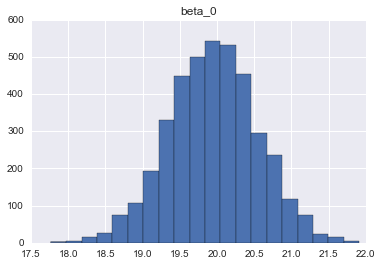

In [150]:
plt.hist(fitdata_b['beta0'],bins=20)
plt.title('beta_0');

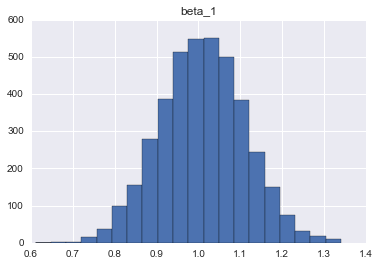

In [151]:
plt.hist(fitdata_b['beta1'],bins=20)
plt.title('beta_1');

## (C)データの101行目から150目

In [218]:
Mydata.iloc[100:150,]

,x1,x2,y
100,6.437847,8.914670,34.921785
101,0.931271,6.355154,24.551838
102,0.780555,4.954432,22.297365
103,6.996715,9.439274,35.300622
104,8.554148,0.195151,18.008446
105,5.288584,1.961516,18.444299
106,1.033909,0.511602,15.273377
107,0.868890,7.490675,24.043826
108,4.019603,0.446168,14.721405
109,4.637931,3.928920,22.327247


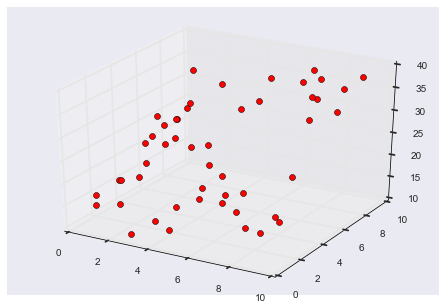

In [212]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot(np.array(Mydata.iloc[100:150,]['x1']),np.array(Mydata.iloc[100:150,]['x2']), np.array(Mydata.iloc[100:150,]['y']), "o", color="#ff0000",ms=6 ,mew=0.5)

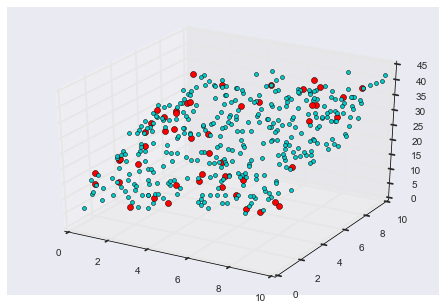

In [215]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot(np.array(Mydata.iloc[100:150,]['x1']),np.array(Mydata.iloc[100:150,]['x2']), np.array(Mydata.iloc[100:150,]['y']), "o", color="#ff0000",ms=6 ,mew=0.5)

ax.plot(np.array(Mydata.iloc[0:100,]['x1']),np.array(Mydata.iloc[0:100,]['x2']), np.array(Mydata.iloc[0:100,]['y']), "o", color="#00cccc",ms=4 ,mew=0.5)
ax.plot(np.array(Mydata.iloc[150:400,]['x1']),np.array(Mydata.iloc[150:400,]['x2']), np.array(Mydata.iloc[150:400,]['y']), "o", color="#00cccc",ms=4 ,mew=0.5)

In [226]:
standata = {'N':50, 'M':3, 'X':X[100:150,:], 'Y':Mydata['y'][100:150]}

In [227]:
fit = sm.sampling(standata)

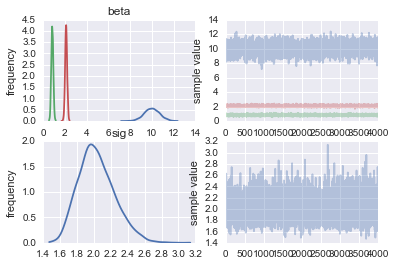

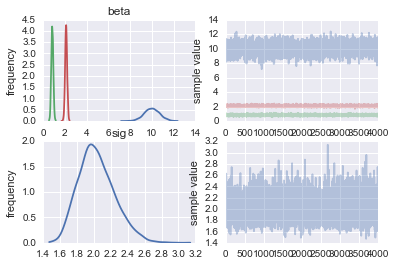

In [228]:
fit.plot()

In [229]:
with open('18_2_c.pickle', 'wb') as f:
    pickle.dump(fit_b,f)

In [230]:
stanfit_to_dataframe(fit)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta[0],10.007093,0.014993,0.700652,8.638845,9.538708,10.005677,10.487325,11.395144,2184.0,1.001985
beta[1],0.836923,0.001921,0.093601,0.658352,0.773318,0.834992,0.900008,1.020267,2374.0,1.001547
beta[2],2.110002,0.001890,0.095325,1.922512,2.047328,2.109380,2.172126,2.300381,2543.0,1.000795
sig,2.033366,0.004010,0.213489,1.670651,1.883806,2.012740,2.167859,2.501130,2835.0,0.999979
lp__,-59.214949,0.033989,1.422671,-62.832451,-59.919280,-58.881791,-58.162171,-57.430144,1752.0,1.000956


In [231]:
data = fit.extract()

In [232]:
fitdata = pd.DataFrame({'beta0' : data['beta'][:,0] , 'beta1' : data['beta'][:,1] , 'beta2' : data['beta'][:,2] , 'sigma' :data['sig']})

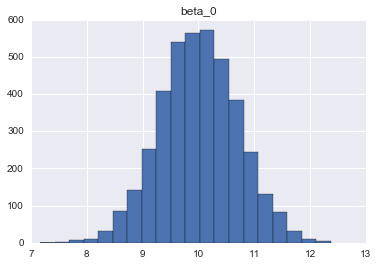

In [233]:
plt.hist(fitdata['beta0'],bins=20)
plt.title('beta_0');

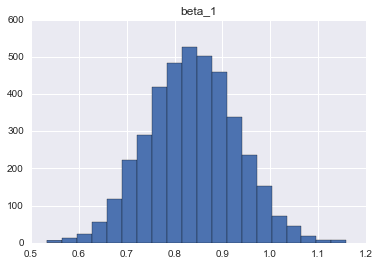

In [234]:
plt.hist(fitdata['beta1'],bins=20)
plt.title('beta_1');

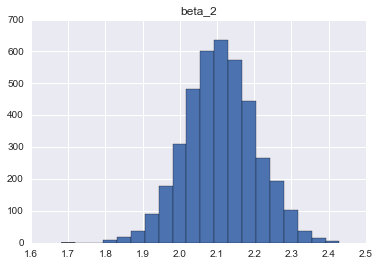

In [235]:
plt.hist(fitdata['beta2'],bins=20)
plt.title('beta_2');

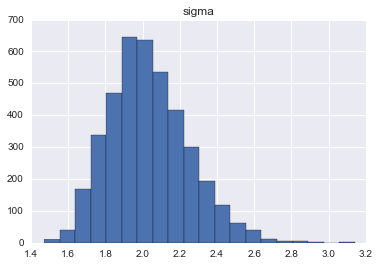

In [236]:
plt.hist(fitdata['sigma'],bins=20)
plt.title('sigma');

## (D)1予測変数

In [237]:
X = np.concatenate([np.ones(N),Mydata['x1']]).reshape(2,N)
X = X.T

In [243]:
standata = {'N':50, 'M':2, 'X':X[100:150,:], 'Y':Mydata['y'][100:150]}

In [244]:
fit_d = sm.sampling(standata)

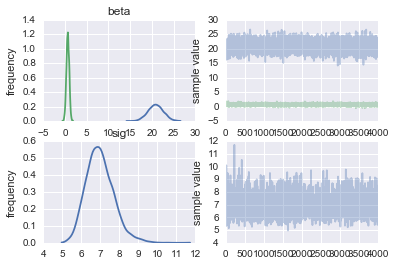

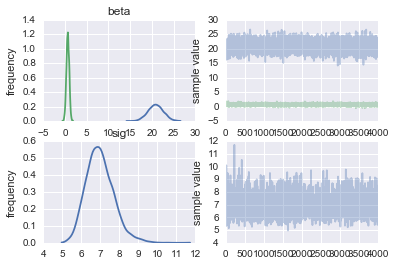

In [245]:
fit_d.plot()

In [246]:
with open('18_2_d.pickle', 'wb') as f:
    pickle.dump(fit_d,f)

In [247]:
stanfit_to_dataframe(fit_d)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta[0],20.882034,0.040852,1.741861,17.494020,19.701533,20.885720,22.045239,24.283827,1818.0,1.000407
beta[1],0.665008,0.007749,0.325459,0.018296,0.448204,0.667335,0.891038,1.281683,1764.0,1.000131
sig,6.985583,0.016145,0.726870,5.748821,6.488591,6.930748,7.423776,8.617055,2027.0,1.003186
lp__,-121.521117,0.033221,1.299455,-124.973429,-122.089972,-121.198221,-120.576977,-120.038438,1530.0,1.000764


## エクササイズ18.2のポイント


- <font size=6>予測変数同士が無相関であっても、$x_2$を加えることで、$x_1$の傾きを正確に推測することができた</font>


- <font size=6>場合によっては、変数選択にも影響を及ぼす</font>


# エクササイズ18.3
【目的：事前分布の確認】

# エクササイズ18.4
【目的：変数選択の実践的体験と事前分布による変化】